In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier



%matplotlib inline



In [ ]:
train_original = pd.read_csv('train/train_metadata.csv')

train_original['image_ID'] = train_original['image_path'].str.slice(start=4, stop=10)

train_index, validation_index, train_label, validation_label = train_test_split(train_original['image_ID'], train_original['ClassId'], test_size=0.2, random_state=66)

color_hist = pd.read_csv('train/Features/color_histogram.csv')

hog_pca = pd.read_csv('train/Features/hog_pca.csv')

additional_feats = pd.read_csv('train/Features/additional_features.csv')

color_hist['image_ID'] = color_hist['image_path'].str.slice(start=4, stop=10)
train_color_hist = color_hist.drop(columns=['image_path']).loc[color_hist['image_ID'].isin(train_index)]
validation_color_hist = color_hist.drop(columns=['image_path']).loc[color_hist['image_ID'].isin(validation_index)]

hog_pca['image_ID'] = hog_pca['image_path'].str.slice(start=4, stop=10)
train_hog = hog_pca.drop(columns=['image_path']).loc[hog_pca['image_ID'].isin(train_index)]
validation_hog = hog_pca.drop(columns=['image_path']).loc[hog_pca['image_ID'].isin(validation_index)]
train_hog.shape, validation_hog.shape

additional_feats['image_ID'] = additional_feats['image_path'].str.slice(start=4, stop=10)
train_additional = additional_feats.drop(columns=['image_path']).loc[additional_feats['image_ID'].isin(train_index)]
validation_additional = additional_feats.drop(columns=['image_path']).loc[additional_feats['image_ID'].isin(validation_index)]

additional_feats['image_ID'] = additional_feats['image_path'].str.slice(start=4, stop=10)
train_additional = additional_feats.drop(columns=['image_path']).loc[additional_feats['image_ID'].isin(train_index)]
validation_additional = additional_feats.drop(columns=['image_path']).loc[additional_feats['image_ID'].isin(validation_index)]
train_additional.shape, validation_additional.shape

train_combined = train_index.to_frame().merge(
    train_color_hist, on='image_ID'
).merge(
    train_hog, on='image_ID'
).merge(train_additional, on='image_ID'
).set_index('image_ID').sort_index()

validation_combined = validation_index.to_frame().merge(
    validation_color_hist, on='image_ID'
).merge(
    validation_hog, on='image_ID'
).merge(validation_additional, on='image_ID'
).set_index('image_ID').sort_index()

train_class = train_label.set_axis(train_index).sort_index()
validation_class = validation_label.set_axis(validation_index).sort_index()

test_original = pd.read_csv('test/test_metadata.csv')
test_original['image_ID'] = test_original['image_path'].str.slice(start=4, stop=10)

test_color = pd.read_csv('test/Features/color_histogram.csv')
test_hog = pd.read_csv('test/Features/hog_pca.csv')
test_additional = pd.read_csv('test/Features/additional_features.csv')

test_color['image_ID'] = test_color['image_path'].str.slice(start=4, stop=10)
test_hog['image_ID'] = test_hog['image_path'].str.slice(start=4, stop=10)
test_additional['image_ID'] = test_additional['image_path'].str.slice(start=4, stop=10)

test_color = test_color.drop(columns=['image_path'])
test_hog = test_hog.drop(columns=['image_path'])
test_additional = test_additional.drop(columns=['image_path'])

test_combined = test_color.merge(
    test_hog, on='image_ID'
    ).merge(
        test_additional, on='image_ID'
    ).set_index('image_ID').sort_index()


### Heat map

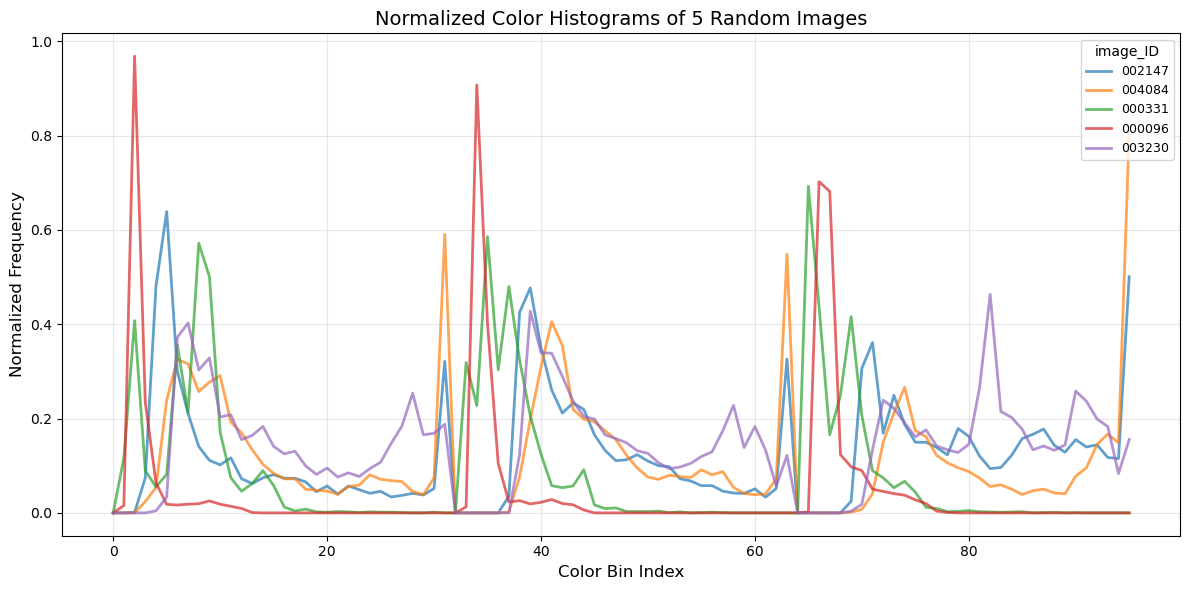

In [255]:
train_color_hist_id = train_color_hist.set_index('image_ID')

sample_df = train_color_hist_id.sample(n=5, random_state=66)


plt.figure(figsize=(12, 6))
for i, (image_id, row) in enumerate(sample_df.iterrows()):
    plt.plot(
        row.values,
        label=image_id,
        linewidth=2,
        alpha=0.7
    )

plt.title("Normalized Color Histograms of 5 Random Images", fontsize=14)
plt.xlabel("Color Bin Index", fontsize=12)
plt.ylabel("Normalized Frequency", fontsize=12)
plt.legend(title="image_ID", loc='upper right', fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

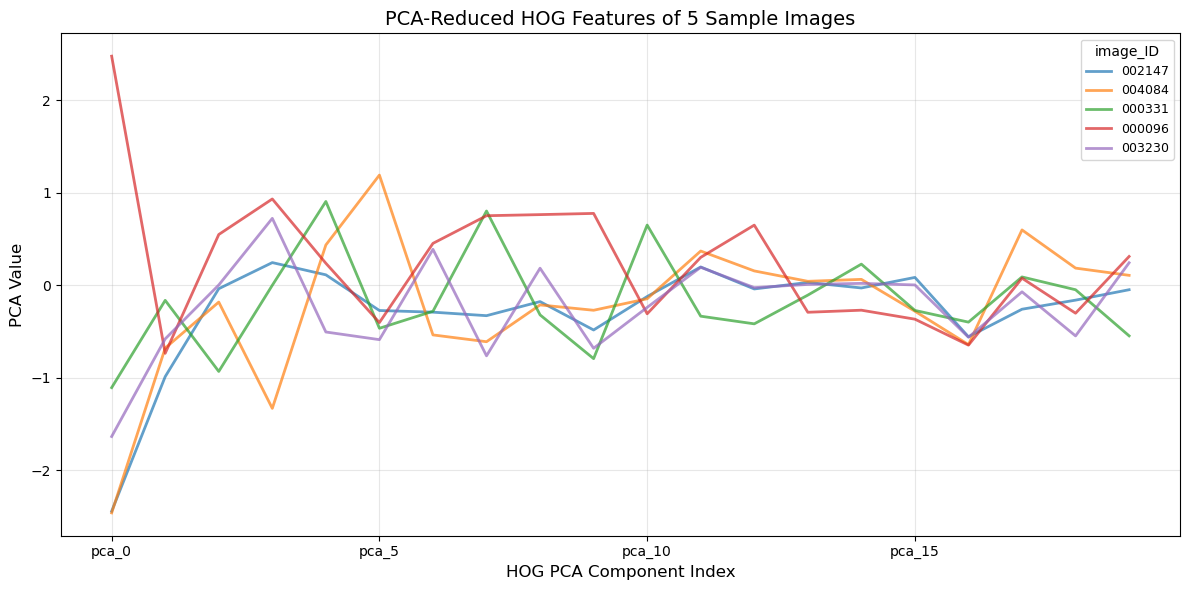

In [256]:
train_hog_id = train_hog.set_index('image_ID')

hog_sample = train_hog_id.sample(n=5, random_state=66)

hog_sample.columns = [f'hog_pca_{i}' for i in range(hog_sample.shape[1])]



plt.figure(figsize=(12, 6))
for i, (image_id, row) in enumerate(hog_sample.iterrows()):
    plt.plot(
        row.values,
        label=image_id,
        linewidth=2,
        alpha=0.7
    )

plt.title("PCA-Reduced HOG Features of 5 Sample Images", fontsize=14)
plt.xlabel("HOG PCA Component Index", fontsize=12)
plt.ylabel("PCA Value", fontsize=12)
plt.xticks(ticks=np.arange(0, hog_sample.shape[1], 5), labels=[f'pca_{i}' for i in range(0, hog_sample.shape[1], 5)])
plt.legend(title="image_ID", fontsize=9, loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

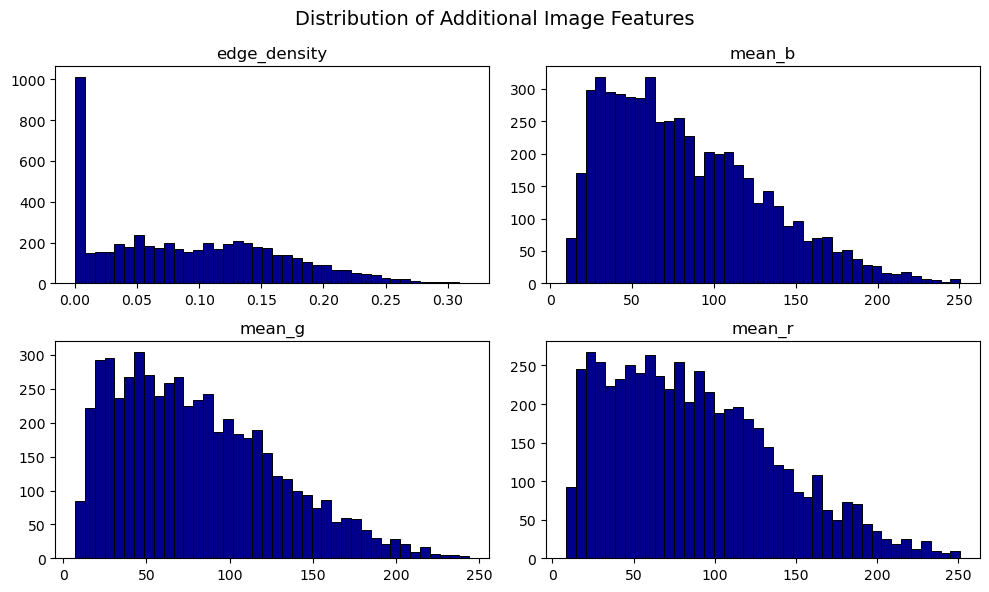

In [ ]:
additional_feats['image_ID'] = additional_feats['image_path'].str.slice(start=4, stop=10)
selected_feats = additional_feats.drop(columns=['image_path', 'image_ID'])

selected_feats.hist(
    bins=40,
    figsize=(10, 6),
    color='darkblue', 
    edgecolor='black',
    linewidth=0.7,
    grid=False
)

plt.suptitle('Distribution of Additional Image Features', fontsize=14)
plt.tight_layout()
plt.show()

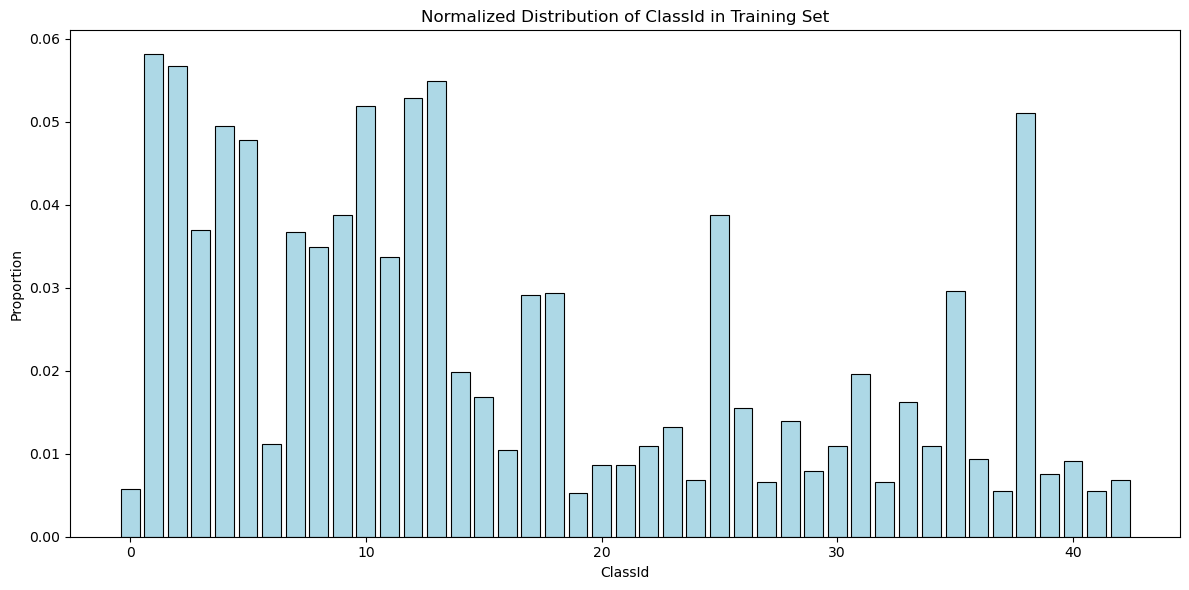

In [ ]:
class_distribution = train_class.value_counts(normalize=True).sort_index()

plt.figure(figsize=(12, 6))
plt.bar(class_distribution.index,
        class_distribution.values,
        color='lightblue',
        edgecolor='black',
        linewidth=0.8)

plt.xlabel('ClassId')
plt.ylabel('Proportion')
plt.title('Normalized Distribution of ClassId in Training Set')
plt.tight_layout()
plt.show()

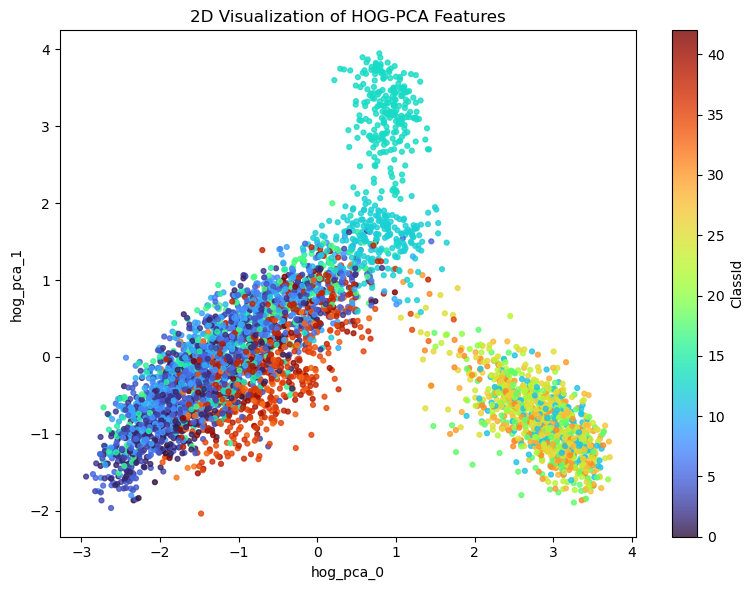

In [ ]:
hog_2d = train_hog[['hog_pca_0', 'hog_pca_1']].copy()
hog_2d['ClassId'] = train_class.values

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    hog_2d['hog_pca_0'],
    hog_2d['hog_pca_1'],
    c=hog_2d['ClassId'],
    cmap='turbo',
    s=12, 
    alpha=0.8
)

plt.xlabel('hog_pca_0')
plt.ylabel('hog_pca_1')
plt.title('2D Visualization of HOG-PCA Features')
plt.colorbar(scatter, label='ClassId')
plt.tight_layout()
plt.show()

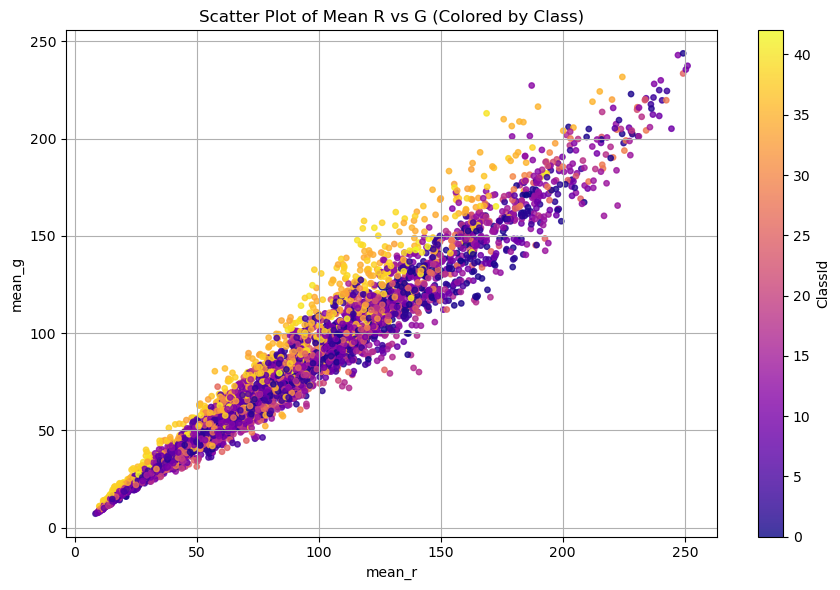

In [260]:
plt.figure(figsize=(9, 6))

plt.scatter(
    train_additional['mean_r'],
    train_additional['mean_g'],
    c=train_class,
    cmap='plasma',
    s=15,
    alpha=0.8
)

plt.xlabel('mean_r')
plt.ylabel('mean_g')
plt.title('Scatter Plot of Mean R vs G (Colored by Class)')
plt.colorbar(label='ClassId')
plt.grid(True)
plt.tight_layout()
plt.show()

### Baseline：Random Forest

In [261]:
rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf.fit(train_combined, train_class)

print("Train Accuracy:", rf.score(train_combined, train_class))
print("Validation Accuracy:", rf.score(validation_combined, validation_class))

Train Accuracy: 1.0
Validation Accuracy: 0.7814207650273224


#### 分类报告 + F1 分数（按类）


Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.59      0.91      0.72        56
           2       0.70      0.80      0.75        66
           3       0.67      0.63      0.65        35
           4       0.86      0.62      0.72        60
           5       0.67      0.64      0.65        50
           6       0.82      0.90      0.86        10
           7       0.84      0.78      0.81        41
           8       0.67      0.75      0.71        44
           9       0.80      0.89      0.84        36
          10       0.81      0.79      0.80        53
          11       0.53      0.70      0.60        37
          12       0.97      1.00      0.98        62
          13       1.00      1.00      1.00        61
          14       1.00      0.95      0.98        22
          15       0.70      0.50      0.58        14
          16       1.00      0.62      0.76        13
  

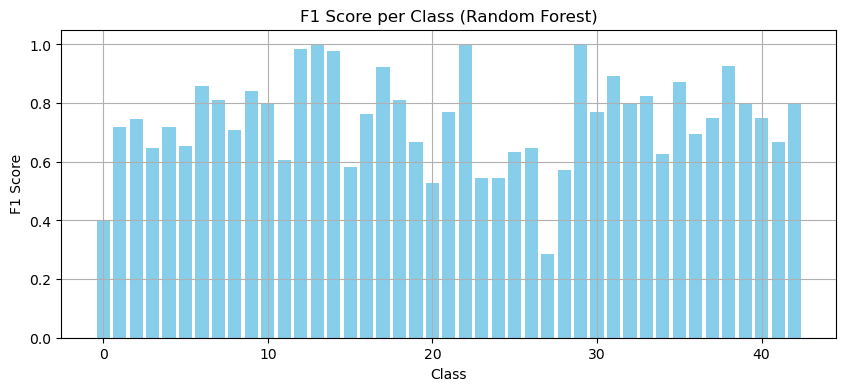

In [ ]:
validation_pred = rf.predict(validation_combined)

print("\nClassification Report:\n")
print(classification_report(validation_class, validation_pred))

f1_per_class = f1_score(validation_class, validation_pred, average=None)
plt.figure(figsize=(10, 4))
plt.bar(np.sort(validation_class.unique()), f1_per_class, color='skyblue')
plt.title("F1 Score per Class (Random Forest)")
plt.xlabel("Class")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()

In [263]:
rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf.fit(train_combined, train_class)

print("Train Accuracy:", rf.score(train_combined, train_class))
print("Validation Accuracy:", rf.score(validation_combined, validation_class))

Train Accuracy: 1.0
Validation Accuracy: 0.7814207650273224



Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.59      0.91      0.72        56
           2       0.70      0.80      0.75        66
           3       0.67      0.63      0.65        35
           4       0.86      0.62      0.72        60
           5       0.67      0.64      0.65        50
           6       0.82      0.90      0.86        10
           7       0.84      0.78      0.81        41
           8       0.67      0.75      0.71        44
           9       0.80      0.89      0.84        36
          10       0.81      0.79      0.80        53
          11       0.53      0.70      0.60        37
          12       0.97      1.00      0.98        62
          13       1.00      1.00      1.00        61
          14       1.00      0.95      0.98        22
          15       0.70      0.50      0.58        14
          16       1.00      0.62      0.76        13
  

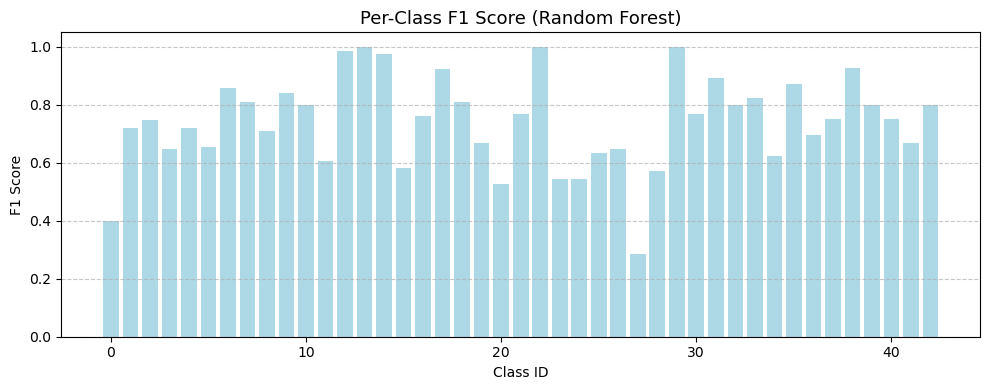

In [264]:
v_pred = rf.predict(validation_combined)

print("\nClassification Report:\n")
print(classification_report(validation_class, v_pred))

f1_scores = f1_score(validation_class, v_pred, average=None)

plt.figure(figsize=(10, 4))
plt.bar(np.sort(validation_class.unique()), f1_scores, color='lightblue')
plt.title("Per-Class F1 Score (Random Forest)", fontsize=13)
plt.xlabel("Class ID")
plt.ylabel("F1 Score")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### 错误分析（示例：分析真实为 4 的预测错样本）

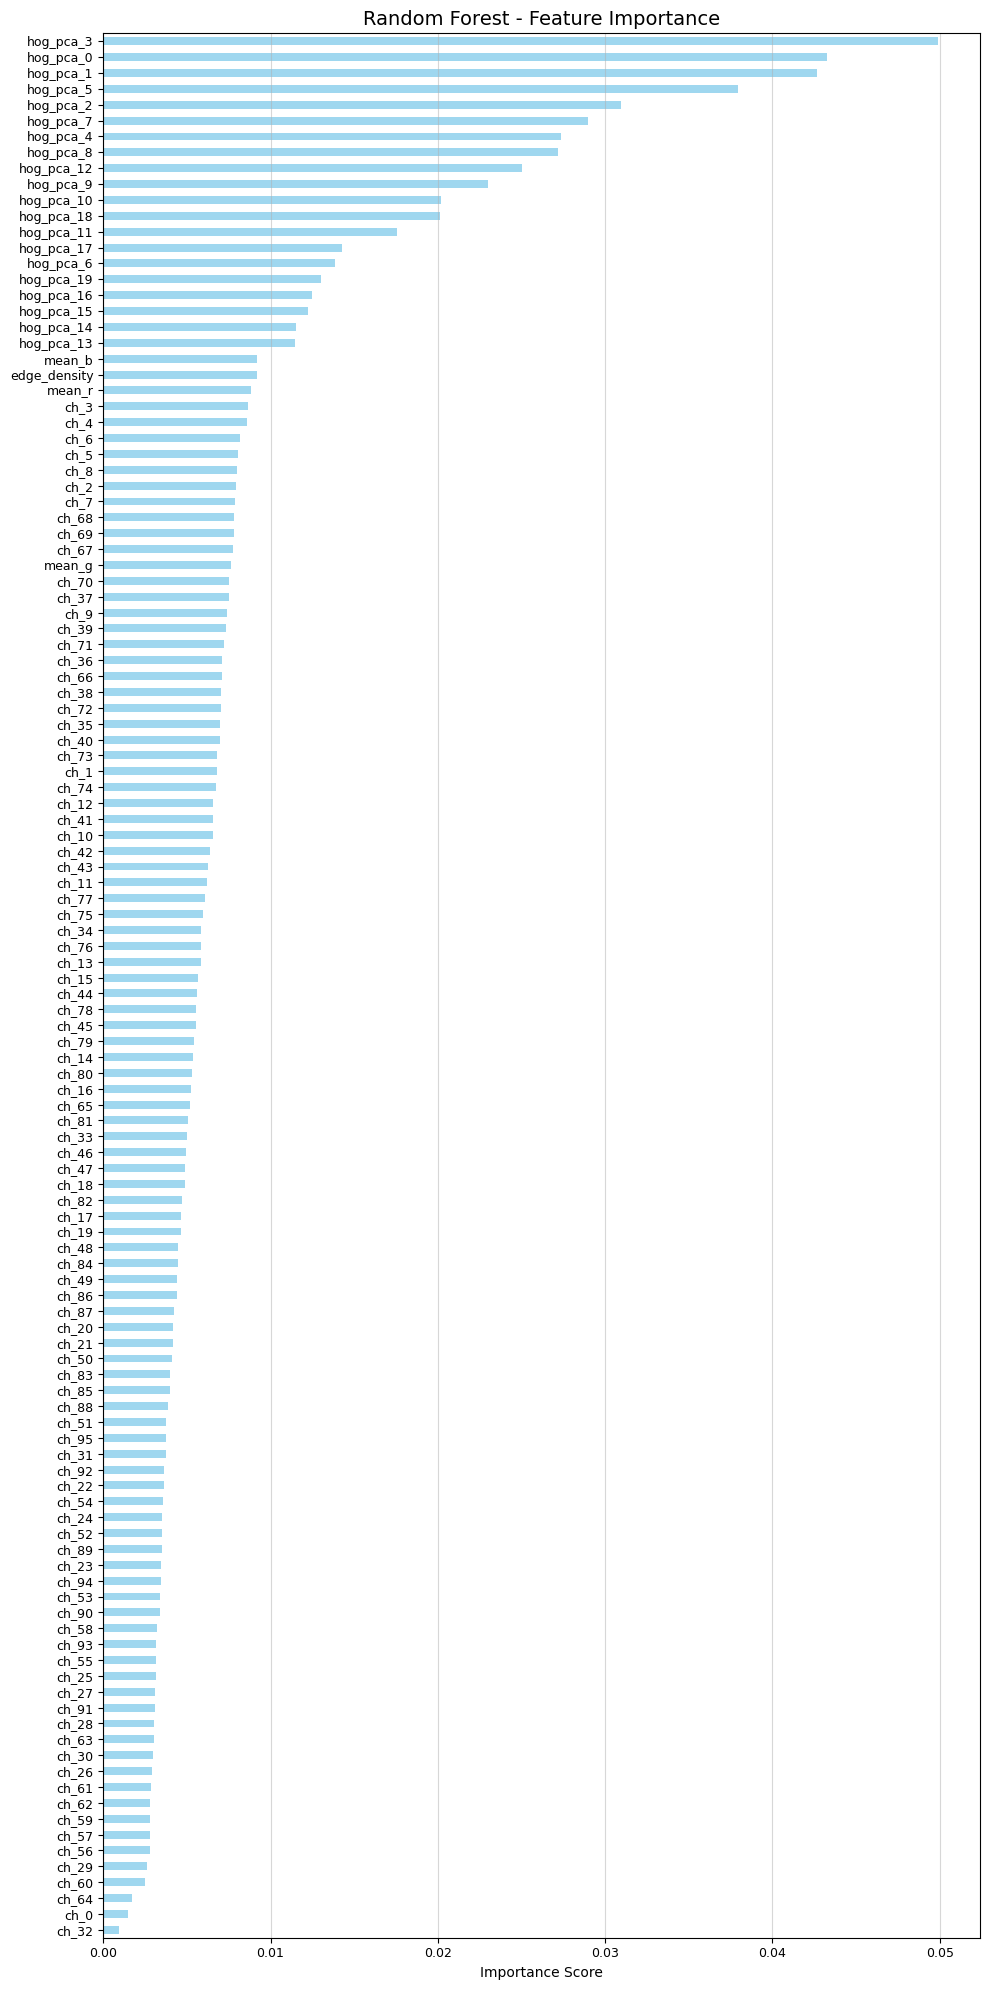

In [265]:
plt.figure(figsize=(10, 20))

pd.Series(rf.feature_importances_, index=train_combined.columns).sort_values().plot.barh(color='skyblue', alpha=0.8, fontsize=9)

plt.title("Random Forest - Feature Importance", fontsize=14)
plt.xlabel("Importance Score")
plt.grid(axis='x', linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()

#### 特征消融

In [266]:
rf_ablate = RandomForestClassifier(random_state=42)
rf_ablate.fit(train_combined.drop(columns=['mean_r', 'mean_g', 'mean_b']), train_class)

print("Without RGB - Dev Accuracy:",rf_ablate.score(validation_combined.drop(columns=['mean_r', 'mean_g', 'mean_b']), validation_class))

Without RGB - Dev Accuracy: 0.7795992714025501


#### 合并数据集

In [267]:

rf_ablate = RandomForestClassifier(random_state=42)
rf_ablate.fit(train_combined.drop(columns=['mean_r', 'mean_g', 'mean_b']), train_class)

print("Without RGB - Dev Accuracy:",rf_ablate.score(validation_combined.drop(columns=['mean_r', 'mean_g', 'mean_b']), validation_class))

test_combined = test_hog.merge(test_color, on='image_ID') \
                        .merge(test_additional, on='image_ID') \
                        .set_index('image_ID') \
                        .sort_index()


Without RGB - Dev Accuracy: 0.7795992714025501


In [268]:
test_combined_aligned = test_combined[train_combined.columns]
rf_prediction = rf.predict(test_combined_aligned)

test_metadata = pd.read_csv('test/test_metadata.csv')
submission_df = pd.DataFrame({
    'id': test_metadata['id'],
    'ClassId': rf_prediction
})
submission_df.to_csv('submission_rf.csv', index=False)

### KNN

In [269]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_combined, train_class)

print("Train Accuracy:", knn.score(train_combined, train_class))
print("Validation Accuracy:", knn.score(validation_combined, validation_class))

Train Accuracy: 0.6605922551252847
Validation Accuracy: 0.37249544626593806


In [270]:
test_combined_aligned = test_combined[train_combined.columns]

test_prediction_knn = knn.predict(test_combined_aligned)

submission_knn = pd.DataFrame({
    'id': test_metadata['id'],
    'ClassId': test_prediction_knn
})

submission_knn.to_csv('submission_knn.csv', index=False)

### MLP

In [271]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_combined)

mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp.fit(train_scaled, train_class)

dev_scaled = scaler.transform(validation_combined)
print("MLP Dev Accuracy:", mlp.score(dev_scaled, validation_class))

MLP Dev Accuracy: 0.8397085610200364


In [272]:

hog_test = pd.read_csv("test/Features/hog_pca.csv")
ch_test = pd.read_csv("test/Features/color_histogram.csv")
additional_test = pd.read_csv("test/Features/additional_features.csv")

for df in [hog_test, ch_test, additional_test]:
    df["image_id"] = df["image_path"].str.slice(start=4, stop=10)

test_combined = hog_test.drop(columns=["image_path"]) \
    .merge(ch_test.drop(columns=["image_path"]), on="image_id") \
    .merge(additional_test.drop(columns=["image_path"]), on="image_id") \
    .set_index("image_id").sort_index()


In [273]:
test_scaled = scaler.transform(test_combined[train_combined.columns])

test_prediction_mlp = mlp.predict(test_scaled)

test_metadata = pd.read_csv("test/test_metadata.csv")

submission_mlp = pd.DataFrame({
    "id": test_metadata["id"],
    "ClassId": test_prediction_mlp
})

submission_mlp.to_csv("submission_mlp.csv", index=False)



In [274]:
train_accuracy = mlp.score(train_scaled, train_class)
validation_accuracy = mlp.score(dev_scaled, validation_class)

print("Train Accuracy:", train_accuracy)
print("Dev Accuracy:", validation_accuracy)

validation_pred = mlp.predict(dev_scaled)
print(classification_report(validation_class, validation_pred))

misclassified_samples = validation_class[validation_class != validation_pred]
misclassified_samples


Train Accuracy: 1.0
Dev Accuracy: 0.8397085610200364
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.72      0.86      0.78        56
           2       0.77      0.74      0.75        66
           3       0.73      0.86      0.79        35
           4       0.80      0.67      0.73        60
           5       0.79      0.82      0.80        50
           6       1.00      0.90      0.95        10
           7       0.85      0.80      0.82        41
           8       0.74      0.84      0.79        44
           9       0.84      0.86      0.85        36
          10       0.94      0.89      0.91        53
          11       0.79      0.70      0.74        37
          12       0.98      0.97      0.98        62
          13       0.98      0.98      0.98        61
          14       0.95      0.95      0.95        22
          15       0.83      0.71      0.77        14
          16       0.85     

image_ID
000022    33
000077    10
000115     8
000130    31
000139     1
          ..
005343     4
005348     8
005407    19
005426    34
005436     6
Name: ClassId, Length: 176, dtype: int64

### SVM

In [275]:
train_scaled = scaler.fit_transform(train_combined)
dev_scaled = scaler.transform(validation_combined)

In [276]:
svm = SVC(kernel='rbf', C=1.0, class_weight='balanced', random_state=42)
svm.fit(train_scaled, train_class)

SVC(class_weight='balanced', random_state=42)

In [277]:
print("Train Accuracy:", svm.score(train_scaled, train_class))
print("Dev Accuracy:", svm.score(dev_scaled, validation_class))

Train Accuracy: 0.8644646924829157
Dev Accuracy: 0.7285974499089253


In [278]:
test_combined = hog_test.drop(columns=["image_path"]) \
    .merge(ch_test.drop(columns=["image_path"]), on="image_id") \
    .merge(additional_test.drop(columns=["image_path"]), on="image_id") \
    .set_index("image_id").sort_index()

test_scaled = scaler.transform(test_combined[train_combined.columns])

test_prediction_svm = svm.predict(test_scaled)

In [279]:
submission_svm = pd.DataFrame({
    'id': test_metadata['id'],
    'ClassId': test_prediction_svm
})
submission_svm.to_csv('submission_svm.csv', index=False)